# Importing the required packages

In [1]:
import numpy as np
import pandas as pd 
import cv2
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import random
from tensorflow.keras.layers import *
from tensorflow.keras import Sequential
from tensorflow.keras.losses import *
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Model
from keras.utils import to_categorical
from sklearn.cluster import MiniBatchKMeans

2024-05-03 15:34:05.444694: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-03 15:34:05.444806: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-03 15:34:05.575613: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Loading MASSEY data

In [2]:
images = []
output = []
for dirname, _, filenames in os.walk(r'/kaggle/input/massey-32x/MASSEY_DATASET'):
    for filename in filenames:
        image = cv2.imread(os.path.join(dirname, filename), 0)
        image = cv2.resize(image, (200, 200))
        images.append(image)
        output.append(filename[6])
plt.show()

# Displaying the images

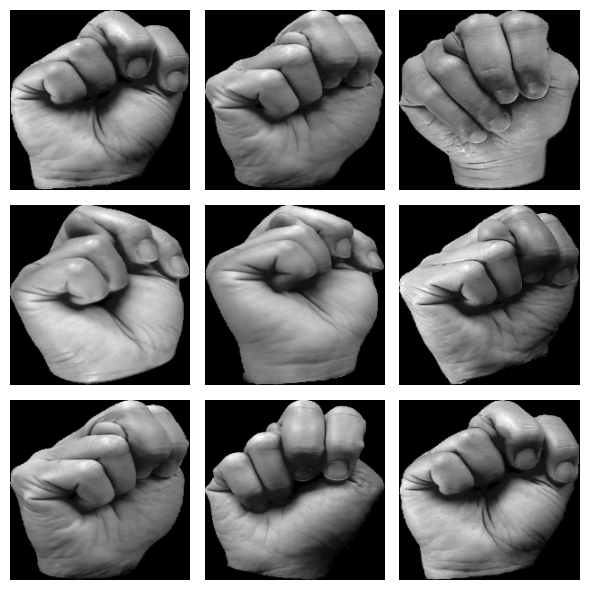

In [36]:
fig, axs = plt.subplots(3, 3, figsize=(6, 6))
for i in range(3):
    for j in range(3):
        axs[i, j].imshow(images[i*3 + j], cmap = 'gray')
        axs[i, j].axis('off') 
plt.tight_layout()
plt.show()

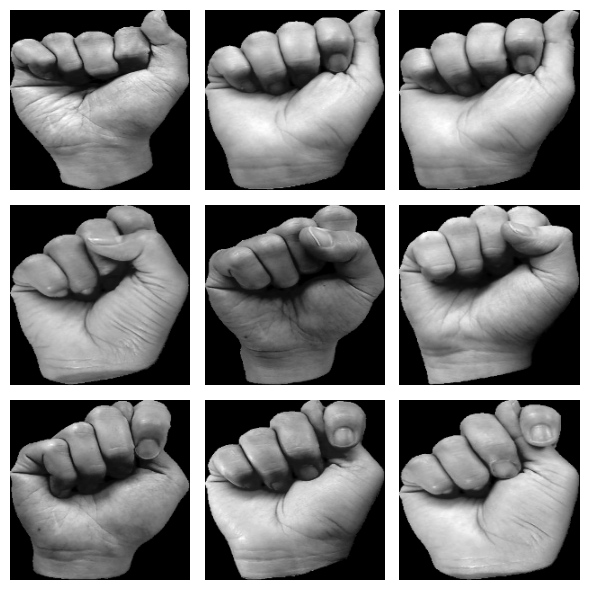

In [37]:
a_images = [images[i] for i in range(len(images)) if output[i] == 'a']
s_images = [images[i] for i in range(len(images)) if output[i] == 's']
t_images = [images[i] for i in range(len(images)) if output[i] == 't']
row_labels = ['a', 's', 't']
fig, axs = plt.subplots(3, 3, figsize=(6, 6))
for i in range(3):
    for j in range(3):
        if i == 0:
            axs[i, j].imshow(a_images[i*3 + j], cmap = 'gray')
        elif i == 1:
            axs[i, j].imshow(s_images[i*3 + j], cmap = 'gray')
        else:
            axs[i, j].imshow(t_images[i*3 + j], cmap = 'gray')
        axs[i, j].axis('off') 
    axs[i, 0].set_ylabel(row_labels[i], rotation=0, size='large')
plt.tight_layout()
plt.show()

# Canny Edge Detection
Canny edge detection is a technique to extract useful structural information from different vision objects and dramatically reduce the amount of data to be processed.

In [80]:
edge_detected_images = []
for dirname, _, filenames in os.walk(r'/kaggle/input/massey-32x/MASSEY_DATASET'):
    for filename in filenames:
        image = cv2.imread(os.path.join(dirname, filename), 0)
        edges = cv2.Canny(image, 70, 255) 
        edge_detected_images.append(edges)

3


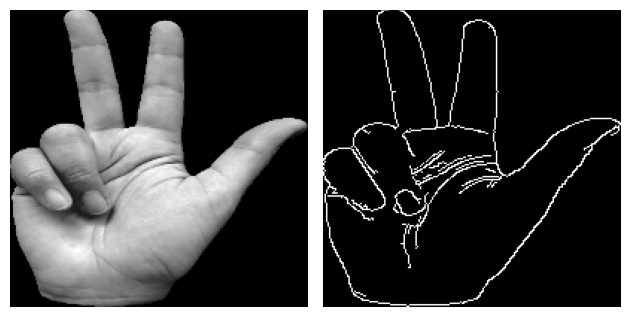

In [39]:
for i in range(2):
    plt.subplot(1, 2, i + 1)
    if i == 0:
        print(output[i+1800])
        plt.imshow(images[i+1800], cmap='gray')
    else:
        plt.imshow(edge_detected_images[i-1+1800], cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()

# ORB detector
ORB is basically a fusion of FAST keypoint detector and BRIEF descriptor with many modifications to enhance the performance. It computes the intensity weighted centroid of the patch with located corner at center. The direction of the vector from this corner point to centroid gives the orientation.

In [81]:
orb_images = []
all_descriptors=[]
orb = cv2.ORB_create(nfeatures=300,edgeThreshold=5)
for image in edge_detected_images:
    keypoints, descriptors = orb.detectAndCompute(image, None)
    all_descriptors.append(descriptors)
    image_with_keypoints = cv2.drawKeypoints(image, keypoints, None)
    orb_images.append(image_with_keypoints)

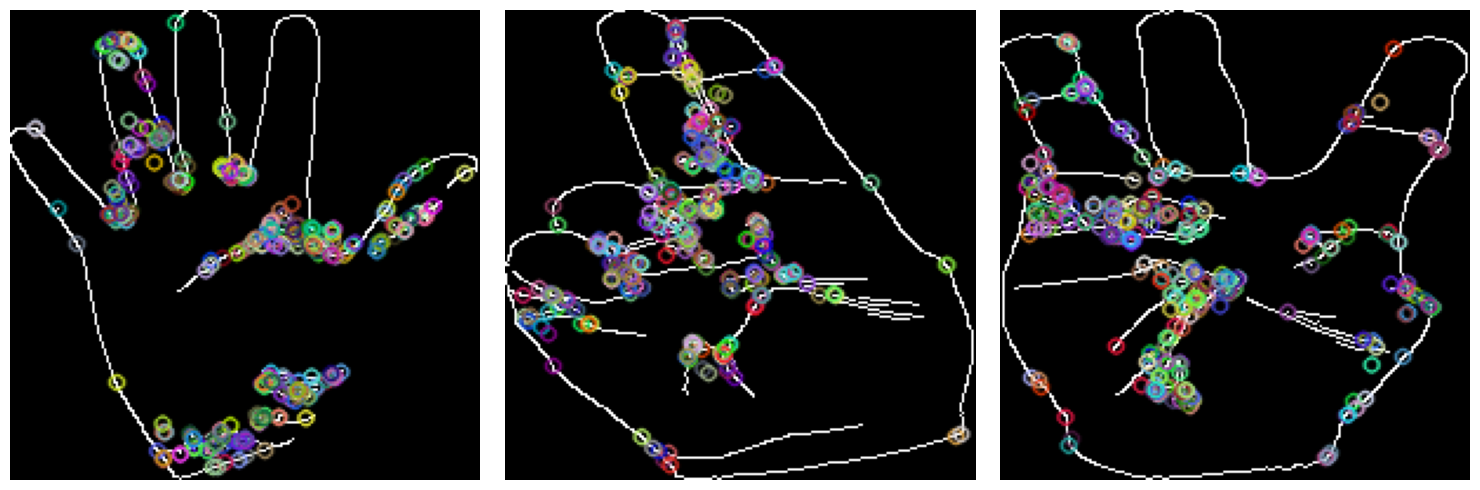

In [82]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i in range(3):
    random_index = random_integer = random.randint(0, len(orb_images))
    axes[i].imshow(cv2.cvtColor(orb_images[random_index], cv2.COLOR_BGR2RGB))
    axes[i].axis('off')
plt.tight_layout()
plt.show()

In [83]:
training_idxs=[i for i in range(0,len(all_descriptors))]

In [84]:
training_descs = [all_descriptors[i] for i in training_idxs]
all_train_descriptors = [desc for desc_list in training_descs for desc in desc_list]
all_train_descriptors = np.array(all_train_descriptors)

# Performing KMeans for clustering the keypoints

In [86]:
from sklearn.cluster import MiniBatchKMeans
def cluster_features(img_descs, cluster_model):
    
    n_clusters = cluster_model.n_clusters

    cluster_model.fit(all_train_descriptors)

    img_clustered_words = [cluster_model.predict(raw_words) for raw_words in all_descriptors]

    img_bow_hist = np.array([np.bincount(clustered_words, minlength=n_clusters) for clustered_words in img_clustered_words])

    X = img_bow_hist

    return X, cluster_model

In [87]:
orb_feature_vector,cluster_model = cluster_features(all_train_descriptors, MiniBatchKMeans(n_clusters=150))

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [88]:
orb_feature_vector.shape

(2515, 150)

# Convolutional Neural Network

## Resizing images to 32x32px

# Applying Gabor filter for 2nd stream

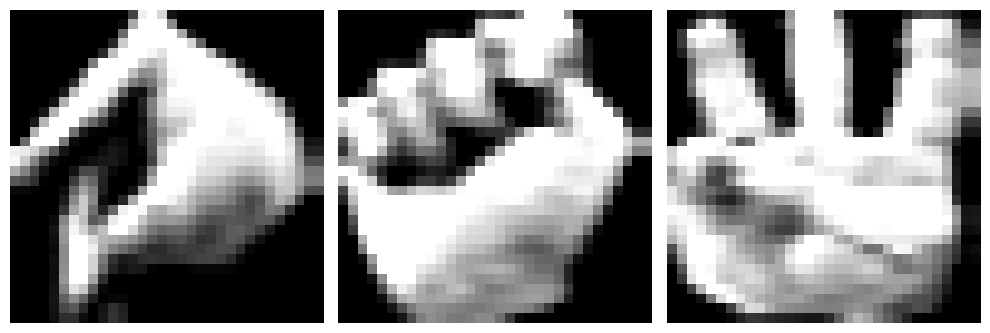

In [89]:
ksize = 10
theta = 0
sigma = 2.0
lamda = 0
gamma = 4.0
phi = 0.5
kern = cv2.getGaborKernel((ksize, ksize),sigma, theta, 8.0, gamma, phi, ktype=cv2.CV_32F)
gabor_filtered_images = []
for image in images:
    image = cv2.resize(image, (32,32))
    filtered_image = cv2.filter2D(image, cv2.CV_8UC3, kern)
    gabor_filtered_images.append(filtered_image)
random_3_images = []
for i in range(3):
    random_integer = random.randint(0, len(images32)-1)
    random_3_images.append(gabor_filtered_images[random_integer])
fig, axes = plt.subplots(1, 3, figsize=(10, 4))
for i, image in enumerate(random_3_images):
    axes[i].imshow(image, cmap='gray')
    axes[i].axis('off')
plt.tight_layout()
plt.show()

# Splitting the dataset
Training set: 60%
Testing set: 30%
Validation set: 10%

In [95]:
#Input images split
input_train, input_test, output_train, output_test = train_test_split(images, output, test_size=0.4, random_state=42)
input_test, input_val, output_test, output_val = train_test_split(input_test, output_test, test_size=0.25, random_state = 42)

#ORB Features split
orb_feature_vector_train,orb_feature_vector_test = train_test_split(orb_feature_vector, test_size = 0.4, random_state = 42)
orb_feature_vector_test, orb_feature_vector_val = train_test_split(orb_feature_vector_test, test_size = 0.25, random_state = 42)


input_train = np.array(input_train)
input_test = np.array(input_test)
input_val = np.array(input_val)
output_train = np.array(output_train)
output_test = np.array(output_test)
output_val = np.array(output_val)

#Gabor input images split
input_train_gabor, input_test_gabor, output_train_gabor, output_test_gabor = train_test_split(gabor_filtered_images, output, test_size=0.4, random_state=42)
input_test_gabor, input_val_gabor, output_test_gabor, output_val_gabor = train_test_split(input_test_gabor, output_test_gabor, test_size=0.25, random_state=42)
input_train_gabor = np.array(input_train_gabor)
input_test_gabor = np.array(input_test_gabor)
input_val_gabor = np.array(input_val_gabor)

# One hot encoding for outputs

In [96]:
label_mapping = {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9,
                 'a': 10, 'b': 11, 'c': 12, 'd': 13, 'e': 14, 'f': 15, 'g': 16, 'h': 17, 'i': 18, 'j': 19,
                 'k': 20, 'l': 21, 'm': 22, 'n': 23, 'o': 24, 'p': 25, 'q': 26, 'r': 27, 's': 28, 't': 29,
                 'u': 30, 'v': 31, 'w': 32, 'x': 33, 'y': 34, 'z': 35}

# Convert output labels to integers using the mapping
output_train = [label_mapping[label] for label in output_train]
output_test = [label_mapping[label] for label in output_test]
output_val = [label_mapping[label] for label in output_val]

output_train = to_categorical(output_train)
output_test = to_categorical(output_test)
output_val = to_categorical(output_val)

# Stream 3 CNN

In [117]:
input_shape = (32, 32, 1)

inputs = Input(shape=input_shape)

conv1 = Conv2D(filters=32, kernel_size=(5, 5), strides=1, padding="valid", activation="relu", name="Layer_1")(inputs)

maxpool1 = MaxPooling2D(pool_size=(2, 2), strides=2, name="Layer_2")(conv1)

conv2 = Conv2D(filters=16, kernel_size=(5, 5), strides=1, padding="valid", activation="relu", name="Layer_3")(maxpool1)

maxpool2 = MaxPooling2D(pool_size=(2, 2), strides=2, name="Layer_4")(conv2)

flatten = Flatten()(maxpool2)

outputs = Dense(36, activation='softmax')(flatten)

stream_3 = Model(inputs=inputs, outputs=outputs)

stream_3.summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Layer_1 (Conv2D)                │ (None, 28, 28, 32)     │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Layer_2 (MaxPooling2D)          │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Layer_3 (Conv2D)                │ (None, 10, 10, 16)     │        12,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Layer_4 (MaxPooling2D)          │ (None, 5, 5, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 36)             │        14,436 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,084 (109.70 KB)

 Trainable params: 28,084 (109.70 KB)

 Non-trainable params: 0 (0.00 B)

In [118]:
stream_3.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [119]:
input_train_32.shape

(1509, 32, 32)

In [120]:
history_stream3 = stream_3.fit(input_train_32, output_train, epochs=80, validation_data = (input_val_32, output_val))

Epoch 1/80
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - categorical_accuracy: 0.0140 - loss: 50.3304 - val_categorical_accuracy: 0.0317 - val_loss: 17.4847
Epoch 2/80
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.0321 - loss: 14.4139 - val_categorical_accuracy: 0.0397 - val_loss: 8.3734
Epoch 3/80
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.0678 - loss: 6.3585 - val_categorical_accuracy: 0.0437 - val_loss: 3.8034
Epoch 4/80
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.0842 - loss: 3.5161 - val_categorical_accuracy: 0.0833 - val_loss: 3.4809
Epoch 5/80
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.1431 - loss: 3.2183 - val_categorical_accuracy: 0.1032 - val_loss: 3.2964
Epoch 6/80
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.1440 - loss: 3.0797 - val_categorical_accuracy: 0.1746 - val_loss: 3.1044
Epoch 7/80
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.2250 - loss: 2.8273 

In [121]:
stream_3.evaluate(input_test_32, output_test)

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - categorical_accuracy: 0.9011 - loss: 0.4598


[0.487087607383728, 0.9018567800521851]

# Evaluation metrics for stream 3

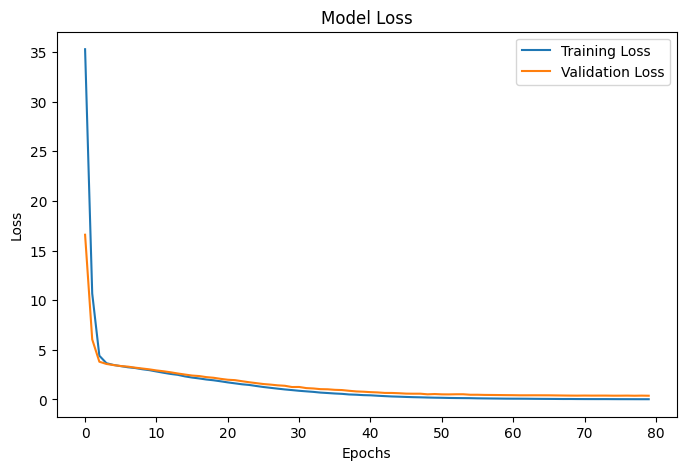

In [56]:
plt.figure(figsize=(8, 5))
plt.plot(history_stream3.history['loss'], label='Training Loss')
plt.plot(history_stream3.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc='upper right')
plt.show()

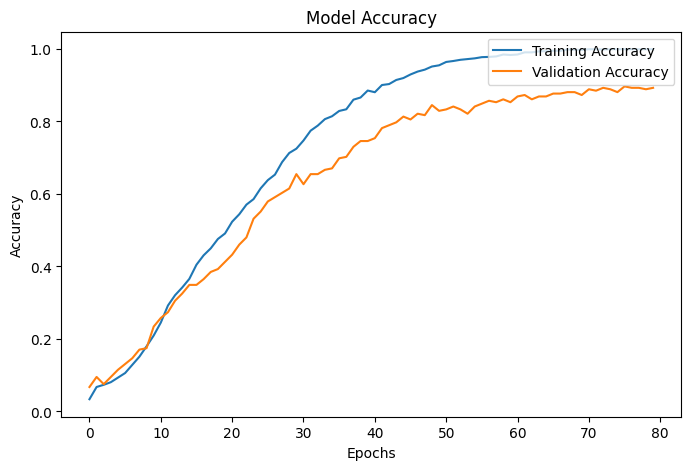

In [57]:
plt.figure(figsize=(8, 5))
plt.plot(history_stream3.history['categorical_accuracy'], label='Training Accuracy')
plt.plot(history_stream3.history['val_categorical_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='upper right')
plt.show()

# Stream 2 + 3 CNN

In [130]:
input1 = Input(shape=(32, 32 ,1))
input2 = Input(shape=(32, 32 ,1))

conv1 = Conv2D(filters=32, kernel_size=(5, 5), strides=1, padding="valid", activation="relu")(input1)
max_pool = MaxPooling2D(pool_size=(2, 2),strides=2)(conv1)

conv2 = Conv2D(filters=16, kernel_size=(5, 5), strides=1, padding="valid", activation="relu")(max_pool)
max_pool1 = MaxPooling2D(pool_size=(2, 2),strides=2)(conv2)

conv3 = Conv2D(filters=32, kernel_size=(5, 5), strides=1, padding="valid", activation="relu")(input2)
max_pool21 = MaxPooling2D(pool_size=(2, 2),strides=2)(conv3)

conv4 = Conv2D(filters=16, kernel_size=(5, 5), strides=1, padding="valid", activation="relu")(max_pool21)
max_pool2 = MaxPooling2D(pool_size=(2, 2),strides=2)(conv4)

concatenated = Concatenate()([max_pool1, max_pool2])

flattened = Flatten()(concatenated)

dropout1 = Dropout(0.63)(flattened)

dense1 = Dense(200, activation='relu')(dropout1)

dropout2 = Dropout(0.23)(dense1)

outputs = Dense(36, activation='softmax')(dropout2)

stream_2_3 = Model(inputs=[input1, input2], outputs=outputs)

stream_2_3.summary()

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 32, 32, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_11      │ (None, 32, 32, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 28, 28,    │        832 │ input_layer_10[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 28, 28,    │        832 │ input_layer_11[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 14, 14,    │          0 │ conv2d_8[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_10    │ (None, 14, 14,    │          0 │ conv2d_10[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 10, 10,    │     12,816 │ max_pooling2d_8[… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 10, 10,    │     12,816 │ max_pooling2d_10… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 5, 5, 16)  │          0 │ conv2d_9[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_11    │ (None, 5, 5, 16)  │          0 │ conv2d_11[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 5, 5, 32)  │          0 │ max_pooling2d_9[… │
│ (Concatenate)       │                   │            │ max_pooling2d_11… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_7 (Flatten) │ (None, 800)       │          0 │ concatenate_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 800)       │          0 │ flatten_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 200)       │    160,200 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 200)       │          0 │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 36)        │      7,236 │ dropout_5[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 194,732 (760.67 KB)

 Trainable params: 194,732 (760.67 KB)

 Non-trainable params: 0 (0.00 B)

In [133]:
stream_2_3.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [134]:
history_2_3 = stream_2_3.fit([input_train_gabor,input_train_32],output_train, epochs=300, validation_data = ([input_val_gabor, input_val_32], output_val))

Epoch 1/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 90ms/step - categorical_accuracy: 0.0374 - loss: 6.9552 - val_categorical_accuracy: 0.1270 - val_loss: 3.3259
Epoch 2/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.0690 - loss: 3.6657 - val_categorical_accuracy: 0.1865 - val_loss: 3.2563
Epoch 3/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.0663 - loss: 3.4885 - val_categorical_accuracy: 0.2302 - val_loss: 3.1520
Epoch 4/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.0926 - loss: 3.3384 - val_categorical_accuracy: 0.2738 - val_loss: 3.0579
Epoch 5/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.1265 - loss: 3.2361 - val_categorical_accuracy: 0.3135 - val_loss: 2.9080
Epoch 6/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.1613 - loss: 3.1249 - val_categorical_accuracy: 0.3571 - val_loss: 2.8339
Epoch 7/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.2099 - loss: 2.9

In [61]:
stream_2_3.evaluate([input_test_gabor,input_test_32],output_test)

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - categorical_accuracy: 0.9502 - loss: 0.1972


[0.20369088649749756, 0.9469496011734009]

# Evaluation metrics for stream 2 and 3

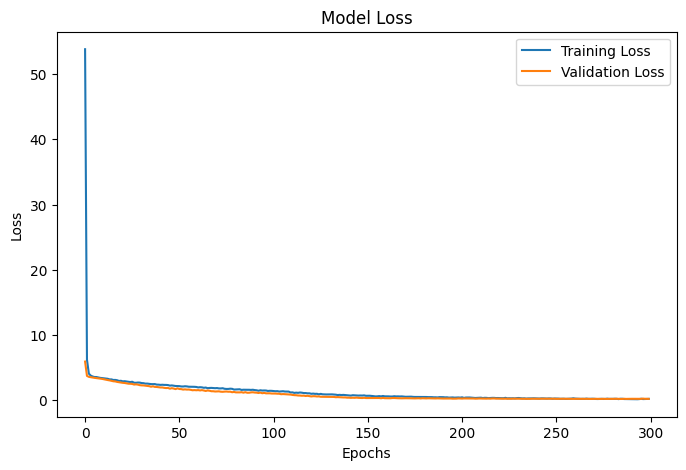

In [62]:
plt.figure(figsize=(8, 5))
plt.plot(history_2_3.history['loss'], label='Training Loss')
plt.plot(history_2_3.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc='upper right')
plt.show()

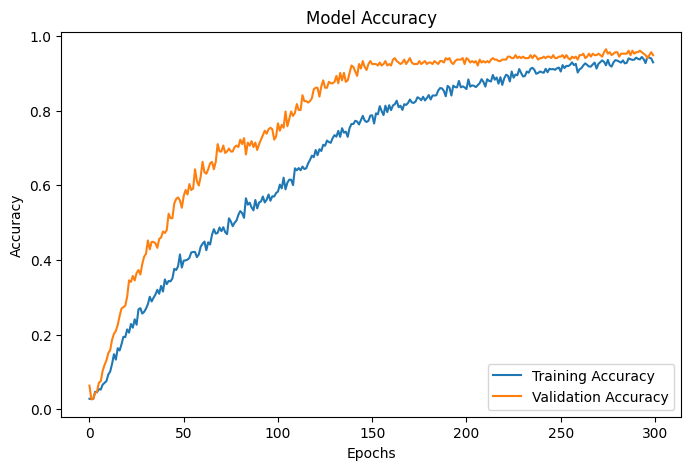

In [63]:
plt.figure(figsize=(8, 5))
plt.plot(history_2_3.history['categorical_accuracy'], label='Training Accuracy')
plt.plot(history_2_3.history['val_categorical_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
plt.show()

# Final Model

In [135]:
input1 = Input(shape=(32, 32, 1))
input2 = Input(shape=(32,32, 1))
inputorb = Input(shape=(150,))

conv1 = Conv2D(filters=32, kernel_size=(5, 5), strides=1, padding="valid", activation="relu")(input1)
max_pool11 = MaxPooling2D(pool_size=(2, 2), strides=2)(conv1)

conv2 = Conv2D(filters = 16, kernel_size=(5, 5), strides=1, padding="valid", activation="relu")(max_pool11)
max_pool12 = MaxPooling2D(pool_size=(2, 2), strides=2)(conv2)

conv3 = Conv2D(filters=32, kernel_size=(5, 5), strides=1, padding="valid", activation="relu")(input2)
max_pool21 = MaxPooling2D(pool_size=(2, 2), strides=2)(conv3)

conv4 = Conv2D(filters = 16, kernel_size=(5, 5), strides=1, padding="valid", activation="relu")(max_pool21)
max_pool22 = MaxPooling2D(pool_size=(2, 2), strides=2)(conv4)

combined_features = Concatenate()([max_pool12, max_pool22])

flattened = Flatten()(combined_features)

dropout1 = Dropout(0.63)(flattened)

dense1 = Dense(200, activation='relu')(dropout1)

dropout2 = Dropout(0.37)(dense1)

combined_features_final = Concatenate()([dropout2, inputorb])

num_classes = 36 
outputs = Dense(num_classes, activation='softmax')(combined_features_final)

model_final = Model(inputs=[input1, input2, inputorb], outputs=outputs)
model_final.summary() 


Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12      │ (None, 32, 32, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_13      │ (None, 32, 32, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 28, 28,    │        832 │ input_layer_12[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 28, 28,    │        832 │ input_layer_13[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_12    │ (None, 14, 14,    │          0 │ conv2d_12[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_14    │ (None, 14, 14,    │          0 │ conv2d_14[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 10, 10,    │     12,816 │ max_pooling2d_12… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 10, 10,    │     12,816 │ max_pooling2d_14… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_13    │ (None, 5, 5, 16)  │          0 │ conv2d_13[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_15    │ (None, 5, 5, 16)  │          0 │ conv2d_15[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 5, 5, 32)  │          0 │ max_pooling2d_13… │
│ (Concatenate)       │                   │            │ max_pooling2d_15… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_8 (Flatten) │ (None, 800)       │          0 │ concatenate_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 800)       │          0 │ flatten_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 200)       │    160,200 │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 200)       │          0 │ dense_11[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_14      │ (None, 150)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 350)       │          0 │ dropout_7[0][0],  │
│ (Concatenate)       │                   │            │ input_layer_14[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 36)        │     12,636 │ concatenate_5[0]… │
└─────────────────────┴───────────────────┴────────────┴─────────────────

 Total params: 200,132 (781.77 KB)

 Trainable params: 200,132 (781.77 KB)

 Non-trainable params: 0 (0.00 B)

In [136]:
model_final.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

In [137]:
history_final = model_final.fit([input_train_gabor,input_train_32,orb_feature_vector_train],output_train, epochs=350, validation_data = ([input_val_gabor, input_val_32, orb_feature_vector_val], output_val))

Epoch 1/350
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 92ms/step - accuracy: 0.0329 - loss: 62.0821 - val_accuracy: 0.0397 - val_loss: 6.0155
Epoch 2/350
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0294 - loss: 8.4247 - val_accuracy: 0.0238 - val_loss: 4.8741
Epoch 3/350
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0338 - loss: 5.5614 - val_accuracy: 0.0317 - val_loss: 4.4981
Epoch 4/350
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0469 - loss: 4.9331 - val_accuracy: 0.0556 - val_loss: 4.3314
Epoch 5/350
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0459 - loss: 4.6746 - val_accuracy: 0.0556 - val_loss: 4.2401
Epoch 6/350
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0585 - loss: 4.4359 - val_accuracy: 0.0556 - val_loss: 4.1848
Epoch 7/350
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0491 - loss: 4.3790 - val_accuracy: 0.0556 - val_loss: 4.1146
Epoch 8/350
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0672 - loss: 4.2122 - val_accuracy: 0.0675 -

# Evaluation metrics for final model

In [138]:
model_final.evaluate([input_test_gabor,input_test_32, orb_feature_vector_test],output_test)

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9074 - loss: 0.2769


[0.30720171332359314, 0.8992042541503906]

In [182]:
%%writefile my_app.py
import streamlit as st
from PIL import Image
import numpy as np
import cv2

def predict_image(image):
    [orb, gabor, img] = preprocess(input_test[0])
    prediction = model_final.predict()
    st.text("Hey")

def main():
    st.title("Hand Gesture Detection")
    uploaded_file = st.file_uploader("Choose an image...", type=["jpg", "png"])
    if uploaded_file is not None:
        file_bytes = np.asarray(bytearray(uploaded_file.read()), dtype=np.uint8)
        image = cv2.imdecode(file_bytes, 0)  
        img = Image.fromarray(image)
        st.image(img, caption='Uploaded Image.', use_column_width=True)
        if st.button('Process Image'):
            predict_image(image)

if __name__ == "__main__":
    main()

Overwriting my_app.py


In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(history_final.history['loss'], label='Training Loss')
plt.plot(history_final.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc='upper right')
plt.show()

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(history_final.history['accuracy'], label='Training Accuracy')
plt.plot(history_final.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [ ]:
output_test = np.argmax(output_test, axis = 1)
predicted = np.argmax(predicted, axis = 1)

In [ ]:
print(classification_report(output_test, predicted))

In [ ]:
import seaborn as sns
labels = [3, 8, 9, 10, 12, 13, 18, 19, 21, 22, 27, 28, 33]
cm = confusion_matrix(output_test, predicted, labels = labels)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True)
labels = ['d','i','j','k','m','n','s','t','v','w','1','2','6']
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels)
plt.yticks(tick_marks, labels, rotation = 360)

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

plt.show()

In [3]:
!pip install tkinter

ERROR: Could not find a version that satisfies the requirement tkinter (from versions: none)
ERROR: No matching distribution found for tkinter
